## Assignment 3 -- SALVADOR GARCIA -- s1655274

# Table of contents
1. [Problem 1: **Generate data** function](#p1) <br /> 
    1.1 [Test for this function](#p1_1)
2. [Problem 2: **SmoothedHingeLoss** function](#p2) <br /> 
    2.1 [Test for this function](#p2_1)
3. [Problem 3: **SGD** function](#p3) <br /> 
    3.1 [Random Generated data with a+ =10, a- =-10 and σ=1.(Easy to separate classes)](#p3_1) <br /> 
    3.2 [Random Generated data with a+ =2, a- =-2 and σ=1.(Medium difficulty to separate classes)](#p3_2) <br /> 
    3.2 [Random Generated data with a+ =1, a- =-1 and σ=1.(Difficult to separate classes)](#p3_3)
4. [Problem 4: **dfSDCA** function](#p4) <br /> 
    4.1 [Comparison SGD and dfSDCA with a+ =10, a- =-10 and σ=1.(Easy to separate classes)](#p4_1) <br /> 
    4.2 [Comparison SGD and dfSDCA with a+ =2, a- =-2 and σ=1.(Medium difficulty to separate classes)](#p4_2) <br /> 
    4.2 [Comparison SGD and dfSDCA with a+ =1, a- =-1 and σ=1.(Difficult to separate classes)](#p4_3)
5. [Problem 5: **mdfSDCA** function](#p5) <br /> 
    5.1 [Convergence with distinct values of tau](#p5.1) <br /> 
    5.2 [Comparison dfSDCA and mdfSDCA in terms of pases over data](#p5.2) <br /> 
    5.3 [Improvement of mdfSDCA](#p5.3)


In [19]:
using PyPlot

<a id = "p1"> </a>

---
## ================================================================
## Problem 1: Generate data function
## ================================================================

In [5]:
function GenerateData(n::Int64, d::Int64, θ::Float64, a_pos, a_neg ,σ::Float64) 
    X = zeros(d, n)
    y = zeros(n)
    for i = 1:n
        t = rand()
        if t < θ
            X[:,i] = (randn(d, 1)*σ + ones(d,1)*a_pos[i])
            y[i] = 1
        else
            X[:,i] = (randn(d, 1)*σ + ones(d,1)*a_neg[i])
            y[i] = -1
        end
    end
    return (X, y)
end 

GenerateData (generic function with 2 methods)

<a id = "p1.1"> </a>

---
To see if this function is correct, the mean and std of a matrix of size $1000000 \times 2$ are calculated:

In [12]:
srand(123456)
p1_X, p1_y = GenerateData(2, 1000000, 0.5, ones(2)*10., ones(2)*(-10.), 1.)
println("Mean and std of the first column of the matrix are: ")
println(mean(p1_X[:,1]));
println(std(p1_X[:,1]));
println("Mean and std of the second column of the matrix are: ")
println(mean(p1_X[:,2]));
println(std(p1_X[:,2]));

Mean and std of the first column of the matrix are: 
-9.999922481788031
1.0005736283063749
Mean and std of the second column of the matrix are: 
9.999248513853095
0.9975349229389672


<a id="p2"></a>

---
## ================================================================
## Problem 2: Generate data function
## ================================================================


In [13]:
function SmoothedHingeLoss(X::Array{Float64,2}, y::Array{Float64,1})
    function SHL(i::Int64, w::Array{Float64, 1})
        z = y[i]*(X[:,i]'*w)[1]     # z = y_i * t
        if z > 1
            return 0
        elseif z < 0
            return (.5 - z)
        else
            return (.5*(1-z)*(1-z))
        end
    end
    
    function SHLgrad(i::Int64, w::Array{Float64, 1})
        z = y[i]*(X[:,i]'*w)[1]     # z = y_i * t
        if z > 1
            return 0
        elseif z < 0
            return (-y[i])
        else
            return (-y[i]+(y[i]*z))
        end
    end
    
    P(w::Array{Float64,1}) = (1/n)*sum([SHL(i,w) for i=1:n]) + (λ/2*w'*w)[1]
    return (SHLgrad, P)
end

SmoothedHingeLoss (generic function with 1 method)

<a id = "p2.1"> </a>

---
To see if this function is correct, an example with $d = 2$, n = $10^3$, $λ = 1/n$, $θ = 0.5$ and $N = 1000$ is used:

In [14]:
# Initial data-------------------------------------------------------------------
srand(123456)
d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 1000

X, y = GenerateData(n, d, θ, ones(n)*10., ones(n)*(-10.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)

(SHLgrad,P)

In [15]:
println(SHLgrad(3, [.01,.01]))
println(P([.01,.01]))

-0.8146621668362124
0.3198231550036817


<a id="p3"></a>

---
## ================================================================
## Problem 3: SGD method
## ================================================================

In [16]:
function SGD(h::Float64, N::Int64, w0::Array{Float64,1})
    fx_val = zeros(floor(Int64, N/10)+1,1)
    w = copy(w0)
    fx_val[1] = P(w)
    for i =1:N
        sel = rand(1:n, 1)[1]
        w = w - h*(SHLgrad(sel, w)*X[:,sel]+ λ*w) 
        if i%10 == 0
            fx_val[floor(Int64, i/10)+1] = P(w)
        end
    end
    return (fx_val, w)
end

SGD (generic function with 1 method)

<a id = "p3.1"> </a>

---
To test the SGD function, three datasets were used with different stepsizes:

---

### 3.1) Random Generated data with $a_+ = 10$, $a_- = -10$ and $σ = 1$.  (easy to separate classes)

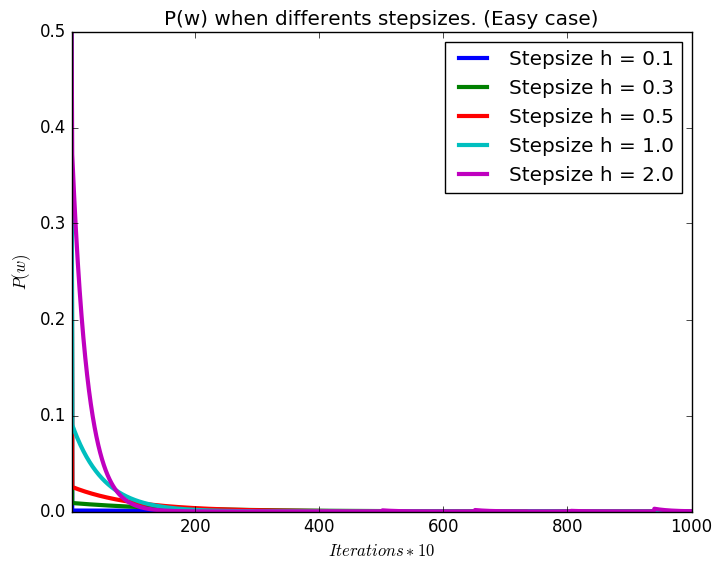

In [21]:
# Initial data-------------------------------------------------------------------
srand(123456)
ax = axes()
d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10000

X, y = GenerateData(n, d, θ, ones(n)*10., ones(n)*(-10.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)

# For different stepsizes -------------------------------------------------------
for i in [0.1, 0.3, 0.5, 1, 2]
    fx_r1, w_sgd1 = SGD(i, N, [0.,0.]);
    plt[:plot](1:(N/10+1), fx_r1, "-", linewidth=3.0, label="Stepsize h = $i")
end
legend(loc="upper right")
xlabel(L"Iterations*10")
ylabel(L"P(w)")
xlim(1, 1000) 
title("P(w) when differents stepsizes. (Easy case)");


For this example, large steps can be made (for example h = 2) without increasing P(w). I think that this can be explained because of the large gap between the means of the generated data (-10 and 10) and a small variance (sigma = 1). This problem is almost completely separable and with a large margin for the parameter w. As this problem probably is separable, the value of the function P(w) is zero.

<a id = "p3.2"> </a>

---
### 3.2) Random Generated data with $a_+ = 2$, $a_- = -2$ and $σ = 1$.  (Medium difficulty to separate classes)

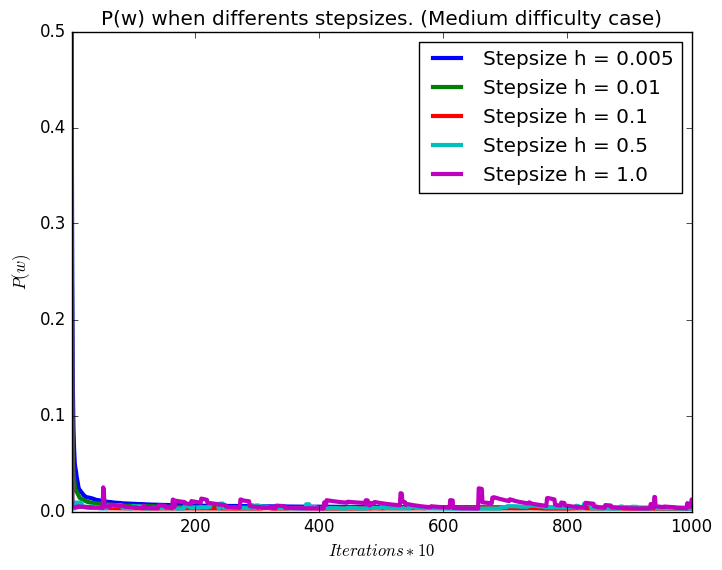

In [22]:
# Initial data-------------------------------------------------------------------
srand(123456)
ax = axes()
d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10000

X, y = GenerateData(n, d, θ, ones(n)*2., ones(n)*(-2.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)

# For different stepsizes -------------------------------------------------------
for i in [0.005, 0.01, 0.1, 0.5, 1]
    fx_r1, w_sgd1 = SGD(i, N, [0.,0.]);
    plt[:plot](1:(N/10+1), fx_r1, "-", linewidth=3.0, label="Stepsize h = $i")
end
legend(loc="upper right")
xlabel(L"Iterations*10")
ylabel(L"P(w)")
xlim(1, 1000) 
title("P(w) when differents stepsizes. (Medium difficulty case)");

In this example, smaller stepsizes can be taken. For example, the largest one that I could find without that P(w) oscillates between more iterations was h = 1. The dfSDCA behaves quite similar as the SGD. And for smaller stepsizes, the convergence is slower. As this problem probably is separable, the value of the function P(w) is zero.

<a id = "p3.3"> </a>

---
### 3.3) Random Generated data with $a_+ = 1$, $a_- = -1$ and $σ = 1$.  (Difficult to separate classes)

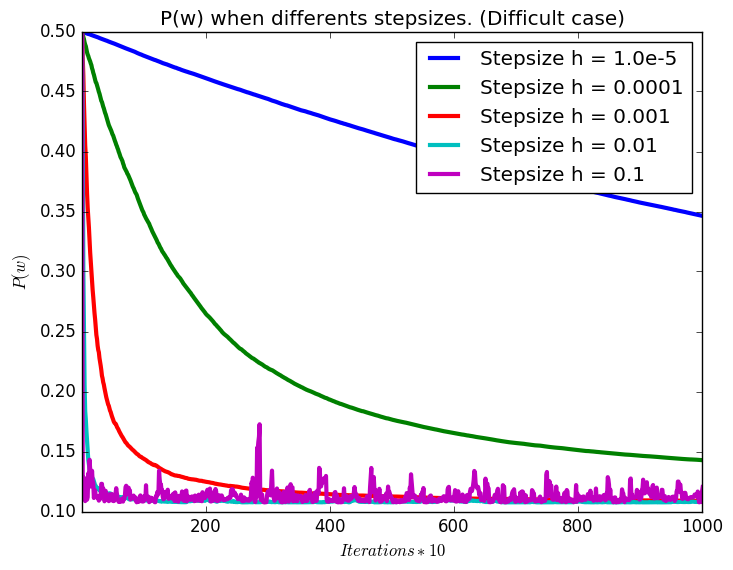

In [23]:
# Initial data-------------------------------------------------------------------
srand(123456)
ax = axes()
d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10000

# For different stepsizes -------------------------------------------------------
X, y = GenerateData(n, d, θ, ones(n)*1., ones(n)*(-1.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)

for i in [0.00001, 0.0001, 0.001, 0.01, .1]
    fx_r1, w_sgd1 = SGD(i, N, [0.,0.]);
    plt[:plot](1:(N/10+1), fx_r1, "-", linewidth=3.0, label="Stepsize h = $i")
end
legend(loc="upper right")
xlabel(L"Iterations*10")
ylabel(L"P(w)")
xlim(1, 1000) 
title("P(w) when differents stepsizes. (Difficult case)");

With this "difficult example" I found that the stepsizes for the SGD should be smaller. The explanation that I found is that, when the best w is found, if you make a large step, you can be changing some of the n summands from 0 (in the case of $y_i t$) to something positive (as the other two cases) and then, increase P(w). This can be the consequence of generating data from two classes that cannot be completely separable given w. The optimal value for this example is close to P(w) = 0.1.

<a id="p4"></a>

---
## ================================================================
## Problem 4: dfSDCA method
## ================================================================

In [24]:
function dfSDCA(N::Int64, α_0::Array{Float64, 1})
    w = (1/(λ*n))*X*α_0
    α = copy(α_0)
    v = convert(Array{Float64,1},[norm(X[:,i])^2 for i=1:n])
    v = maximum(v)
    θ = λ/(v+n*λ)
    w_p = zeros(floor(Int64, N/10)+1,1)
    w_p[1] = P(w)
    
    for k = 1:N
        sel = rand(1:n, 1)[1]
        Δ = -(SHLgrad(sel, w)+α[sel])
        α[sel] += θ*n*Δ
        w += (θ/λ)*Δ*X[:,sel]
        if k%10 == 0
            w_p[floor(Int64, k/10)+1] = P(w)
        end
    end
    return (w_p, w)
end

dfSDCA (generic function with 1 method)

<a id = "p4.1"> </a>

---
Now, an experiment to compare the SGD and the dfSDCA was made. For this, different stepsizes of the SGD were taken (0.1, 0.3, 0.5, 1.0, 2.0) using three different random generated data (separated classes, close clasess but separated, mixed classes):

### 4.1) Randomly Generated data with $a_+ = 10$, $a_- = -10$ and $σ = 1$.  (Easy case)
In this dataset, the classes are separated. The distance between the mean of each column is very large (20 units) in comparison with the standard deviation:

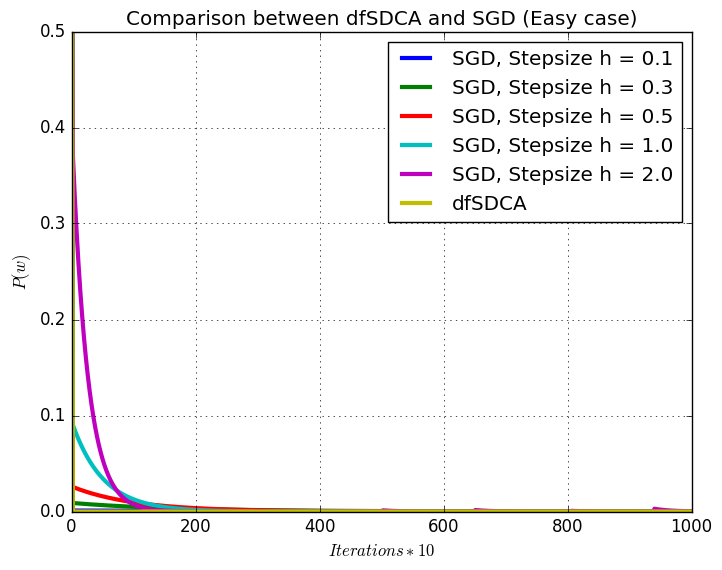

In [25]:
# Initial data -----------------------------------------------------------------------
srand(123456)

d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10*n

X, y = GenerateData(n, d, θ, ones(n)*10., ones(n)*(-10.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)
α_0 = zeros(n);

# SGD calculation----------------------------------------------------------------------
for i in [0.1, 0.3, 0.5, 1, 2]
    fx_r1, w_sgd1 = SGD(i, N, [0.,0.]);
    plt[:plot](1:(N/10+1), fx_r1, "-", linewidth=3.0, label="SGD, Stepsize h = $i")
end

# dfSDCA calculation-------------------------------------------------------------------
w_p, w_orig = dfSDCA(N, α_0);
plt[:plot](1:(n+1), w_p, "-", linewidth=3.0, label="dfSDCA")

legend(loc="upper right")
xlabel(L"Iterations*10")
ylabel(L"P(w)")
title("Comparison between dfSDCA and SGD (Easy case)")
xlim(0, 1000)
grid("on")

<a id = "p4.2"> </a>

---

### 4.2) Random Generated data with $a_+ = 2$, $a_- = -2$ and $σ = 1$.  (Medium difficulty case)

To observe how the value converge to the optimum, for the next examples 100,000 iterations were made. Also, in the next plots a logarithmic scale for y is used. 

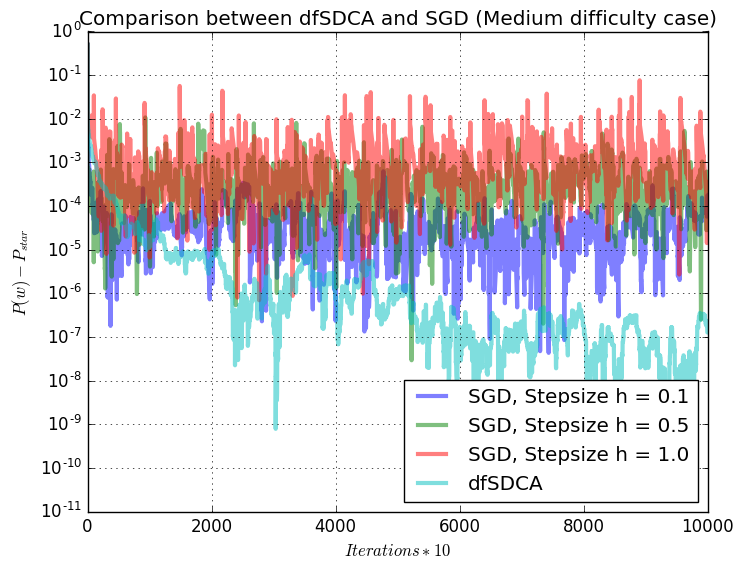

In [26]:
# Initial data -----------------------------------------------------------------------
srand(1234567)
ax = axes()

d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 100*n

X, y = GenerateData(n, d, θ, ones(n)*2., ones(n)*(-2.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)
α_0 = zeros(n);

# Value of the w^star (calculated after 30 pases over the data)-----------------------
(w_p, wstar)  = dfSDCA(300000, α_0) 
Pstar = P(wstar)

# SGD calculation----------------------------------------------------------------------
for i in [0.1, 0.5, 1]
    fx_r1, w_sgd1 = SGD(i, N, [0.,0.]);
    plt[:plot](1:(N/10+1), (fx_r1.-Pstar), "-", linewidth=3.0, label="SGD, Stepsize h = $i", alpha = .5)
end

# dfSDCA calculation-------------------------------------------------------------------
α_0 = zeros(n);
w_p, w_orig = dfSDCA(N, α_0);
plt[:plot](1:(10*n+1), (w_p.-Pstar), "-", linewidth=3.0, label="dfSDCA", alpha = .5)


legend(loc="lower right")
xlabel(L"Iterations*10")
ylabel(L"P(w)-P_{star}")
title("Comparison between dfSDCA and SGD (Medium difficulty case)")
xlim(0, 10000)
ax[:set_yscale]("log")
grid("on")

In this example, the dfSDCA method has a better behavior than the SGD. Also, in the last iterations, it have the closest value to $P(w_{star})$

<a id = "p4.3"> </a>

---

### 4.3) Random Generated data with $a_+ = 1$, $a_- = -1$ and $σ = 1$.  (Difficult case)

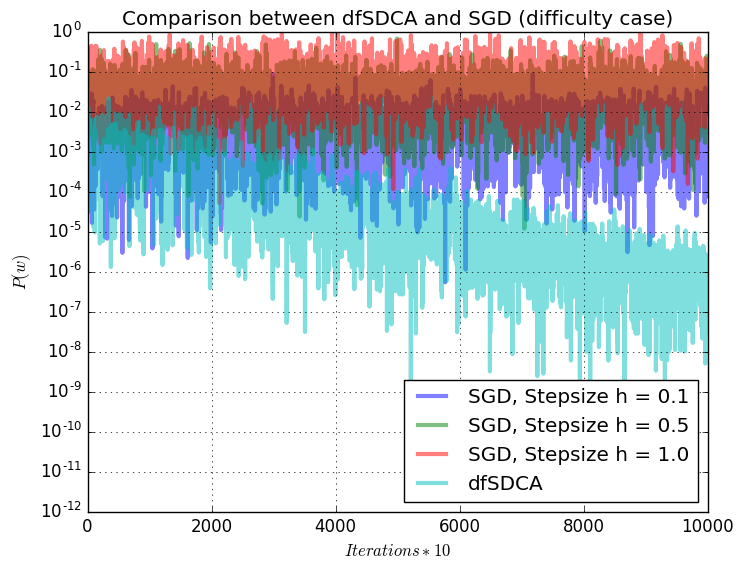

In [27]:
# Initial data -----------------------------------------------------------------------
srand(123456)
ax = axes()

d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 100*n

X, y = GenerateData(n, d, θ, ones(n)*1., ones(n)*(-1.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)
α_0 = zeros(n);

# Value of the w^star (calculated after 30 pases over the data)-----------------------
(w_p, wstar)  = dfSDCA(300000, α_0) 
Pstar = P(wstar)

# SGD calculation----------------------------------------------------------------------
for i in [0.1, 0.5, 1]
    fx_r1, w_sgd1 = SGD(i, N, [0.,0.]);
    plt[:plot](1:(N/10+1), (fx_r1.-Pstar), "-", linewidth=3.0, label="SGD, Stepsize h = $i", alpha = .5)
end

# dfSDCA calculation-------------------------------------------------------------------
w_p, w_orig = dfSDCA(N, α_0);
plt[:plot](1:(10*n+1), (w_p.-Pstar), "-", linewidth=3.0, label="dfSDCA", alpha = .5)

legend(loc="lower right")
xlabel(L"Iterations*10")
ylabel(L"P(w)")
title("Comparison between dfSDCA and SGD (difficulty case)")
xlim(0, 10000)
ylim(.000000000001, 1)
ax[:set_yscale]("log")
grid("on")

The dfSDCA has a better behaviour than the others. As can be seen, this plot has more noise than the two previous, the ones generated from other datasets. I consider that this example is the most difficult of the three because some observations of one class can be misclassified as elements of the other class.

<a id="p5"></a>

---
## ================================================================
## Problem 5: mdfSDCA method
## ================================================================

For this section only the difficult case (a+ = 1, a- = -1 and sigma = 1) will be analysed.

In [28]:
# reservoir sampling for uniform sampling
function samplingK(k, n) 
    reservoir = collect(1:k)
    for i=(k+1):n
        pos = rand(1:i)
        if pos <= k
            reservoir[pos] = i
        end
    end
    return reservoir
end

samplingK (generic function with 1 method)

In [29]:
function mdfSDCA(N, τ, α_0)
    p=ones(n)*τ/n                  # Uniform sampling
    v = [norm(X[:,i])^2 for i=1:n] 
    θ = minimum(p*λ*n./(v + λ*n))
    w = (1/(λ*n))*X*α_0
    α = copy(α_0)
    w_p = zeros(floor(Int64, N/10)+1)
    w_p[1] = P(w)
    for k = 1:N                    # Eficient mdfSDCA
        for i in samplingK(τ,n)    
            Δ = -(SHLgrad(i, w)+α[i])
            α[i] += θ/p[i]*(Δ)
            w += (X[:,i]*θ*Δ) / (λ*n*p[i])
        end
        if k%10 == 0
            w_p[floor(Int64, k/10)+1] = P(w)
        end
    end
    return (w_p, w) 
end

mdfSDCA (generic function with 1 method)

<a id = "p5.1"> </a>

---

### 5.1) mdfSDCA  with different τ for the example of $a_+ = 1$, $a_- = -1$ and $σ = 1$.  (Difficult case) 

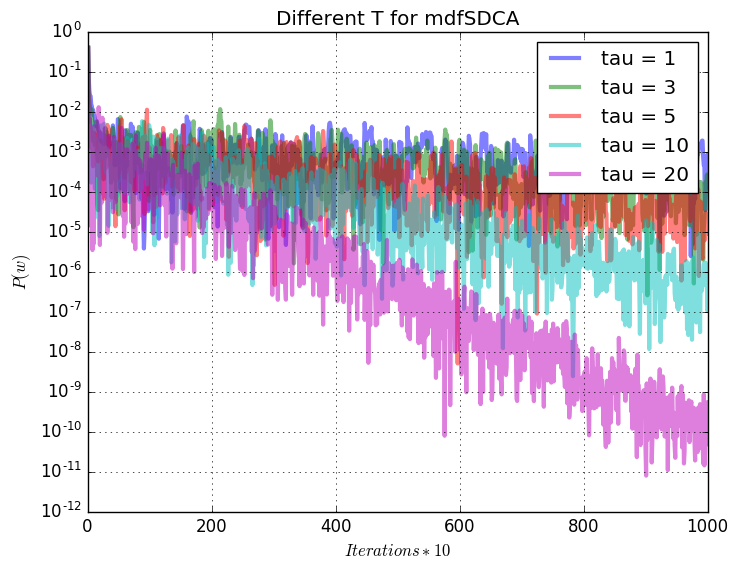

In [30]:
# Initial data -----------------------------------------------------------------------
srand(123456)
ax = axes()

d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10*n

X, y = GenerateData(n, d, θ, ones(n)*1., ones(n)*(-1.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)
α_0 = zeros(n);

# Value of the w^star (calculated after 30 pases over the data)-----------------------
(w_p, wstar)  = dfSDCA(300000, α_0) 
Pstar = P(wstar)

# Comparison for different T ---------------------------------------------------------
for i in [1,3,5,10,20]
    w_p1, w_mult = mdfSDCA(N, i, α_0);
    plt[:plot](1:(N/10+1), abs(w_p1.-Pstar),"-", linewidth=3.0, label="tau = $i", alpha = .5)
end
legend(loc="upper right")
xlabel(L"Iterations*10")
ylabel(L"P(w)")
title("Different T for mdfSDCA")
xlim(0, 1000)
ylim(.000000000001, 1)
ax[:set_yscale]("log")
grid("on")


In this example, we can see that with different values of tau, the value of P(w) have a different behaviour. With values of one and three, the convergence is slower than with large values of tau. Intuitively, this can be explained because each iteration is taking more rows to update (and improve) the value of P(w), so it should work better. I consider this iteration unfair in terms of passes over the data.

<a id = "p5.2"> </a>

---

### 5.2) Fair comparison of mdfSDCA and dfSDCA for the example of $a_+ = 1$, $a_- = -1$ and $σ = 1$.  (Difficult case) 

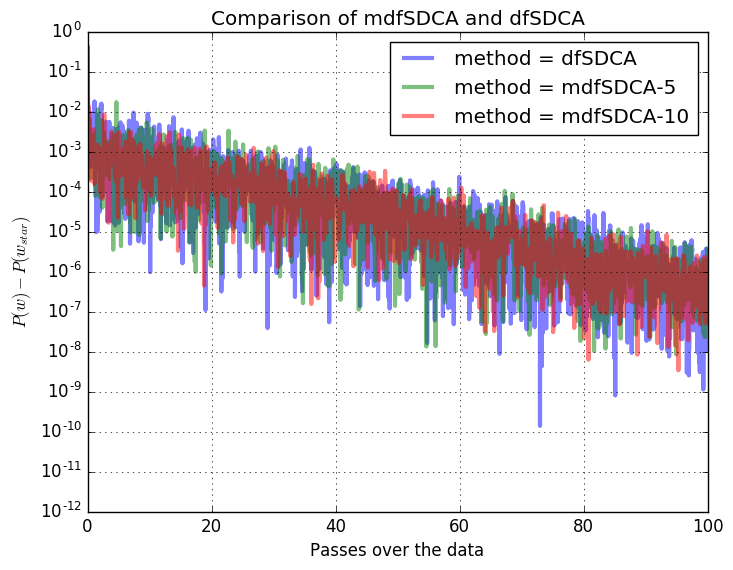

In [31]:
# Initial data -----------------------------------------------------------------------
srand(123456)
d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10000

X, y = GenerateData(n, d, θ, ones(n)*1., ones(n)*(-1.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)

α_0 = zeros(n)

# Value after 10 pases in each of the methods ----------------------------------------
(Pvalues, w_df) = dfSDCA(100000, α_0) # 10 pases over the data (Tau = 1)
(Pvalues2, w_mdf) = mdfSDCA(20000, 5, α_0) # 10 pases over the data (Tau = 5)
(Pvalues3, w_mdf) = mdfSDCA(10000, 10, α_0) # 10 pases over the data (Tau = 10)


# Diference with P(w_star)------------------------------------------------------------
dfSDCA_values = abs(Pvalues .- Pstar);
mdfSDCA5_values = abs(Pvalues2 .- Pstar);
mdfSDCA10_values = abs(Pvalues3 .- Pstar);

# Plot in terms of passes over the data-----------------------------------------------
ax = axes()
plt[:plot]((0:10000)/100, dfSDCA_values, "-", linewidth=3.0, label="method = dfSDCA", alpha = .5)
plt[:plot]((0:2000)/20, mdfSDCA5_values, "-", linewidth=3.0, label="method = mdfSDCA-5", alpha = .5)
plt[:plot]((0:1000)/10, mdfSDCA10_values, "-", linewidth=3.0, label="method = mdfSDCA-10", alpha = .5)
legend(loc="upper right")
xlabel("Passes over the data")
ylabel(L"P(w)-P(w_{star})")
title("Comparison of mdfSDCA and dfSDCA")
xlim(0,100)
ylim(.000000000001, 1)
ax[:set_yscale]("log")
grid("on")

In the above plot, the dfSDCA has a similar performance with the mdfSDCA when a fair comparison is used(passes over complete dataset). I believe that this is because we are comparing the convergence in terms of the number of used rows. This way, one iteration of the mdfSDCA with Tau = 10, updates (uses) 10 rows. On the other hand, the original dfSDCA just uses 1. The same argument works with the example that uses Tau = 5 in comparison with the original method and with the mdfSDCA with Tau = 10. Also, less noise is observed when updating more entries per iteration.

<a id = "p5.3"> </a>

---

### 5.3) Importance sampling for mdfSDCA

In [41]:
# For importance sampling, I am not sure about how to update θ (this example was not seen in class, so I prefer to take
# a conservative step to guarantee convergence) 
include("probability_tree.jl")

function mdfSDCA_imp(N, τ, α_0)
    v = [norm(X[:,i])^2 for i=1:n] 
    p_imp = v + λ*n
    # p_imp = τ*p_imp/sum(p_imp) # I'm not sure about this formula, in the slides of lecture 8, there is no formula
    # for minibatch importance sampling. Then, I will take a conservative step:
    p_imp = p_imp/sum(p_imp)
    θ = minimum(p_imp*λ*n./(v + λ*n)) 
    w = (1/(λ*n))*X*α_0                
    α = copy(α_0)
    w_p = zeros(floor(Int64, N/10)+1)
    w_p[1] = P(w)
    PT = PTCreate(p_imp) # creates the probability tree
    
    for k = 1:N
        for i in 1:τ    # efficient mdfSDCA
            i = PTSample(PT) # sample a coordinate according to distribution p
            Δ = -(SHLgrad(i, w)+α[i])
            α[i] += θ/p_imp[i]*(Δ)
            w += (X[:,i]*θ*Δ) / (λ*n*p_imp[i])
        end
        if k%10 == 0
            w_p[floor(Int64, k/10)+1] = P(w)
        end
    end
    return (w_p, w) 
end

mdfSDCA_imp (generic function with 1 method)

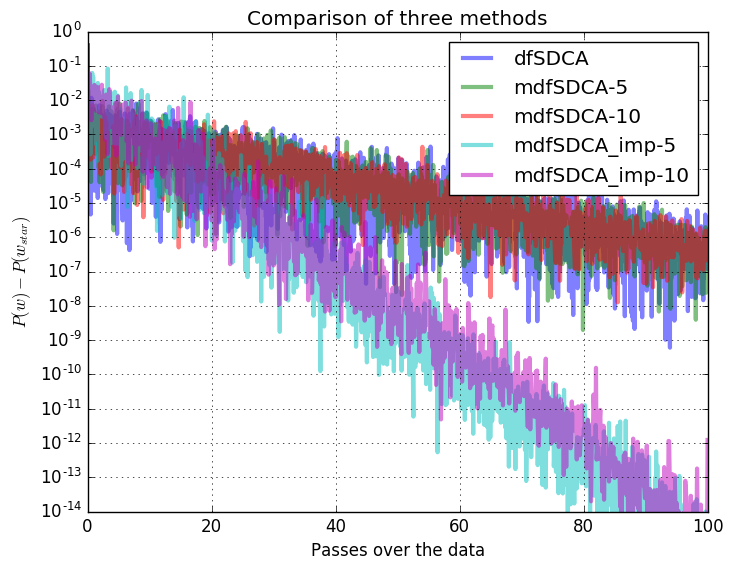

In [42]:
# Initial data -----------------------------------------------------------------------
srand(123456)
d = 2
n = 10^3
λ = 1/n
θ = 0.5
N = 10000

X, y = GenerateData(n, d, θ, ones(n)*1., ones(n)*(-1.), 1.);
SHLgrad, P = SmoothedHingeLoss(X, y)

α_0 = zeros(n)

# Value of the w^star (calculated after 30 pases over the data)-----------------------
(w_p, wstar)  = dfSDCA(300000, α_0) 
Pstar = P(wstar)

# Value after 10 pases in each of the methods ----------------------------------------
(Pvalues, w_df) = dfSDCA(100000, α_0) # 10 pases over the data (Tau = 1)
(Pvalues2, w_mdf) = mdfSDCA(20000, 5, α_0) # 10 pases over the data (Tau = 5)
(Pvalues3, w_mdf) = mdfSDCA(10000, 10, α_0) # 10 pases over the data (Tau = 10)
(Pvalues4, w_mdf) = mdfSDCA_imp(20000, 5, α_0) # 10 pases over the data (Tau = 5)
(Pvalues5, w_mdf) = mdfSDCA_imp(10000, 10, α_0) # 10 pases over the data (Tau = 10)

# Diference with P(w_star)------------------------------------------------------------
dfSDCA_values = abs(Pvalues .- Pstar);
mdfSDCA5_values = abs(Pvalues2 .- Pstar);
mdfSDCA10_values = abs(Pvalues3 .- Pstar);
mdfSDCA5_imp_values = abs(Pvalues4 .- Pstar);
mdfSDCA10_imp_values = abs(Pvalues5 .- Pstar);

# Plot in terms of passes over the data-----------------------------------------------
ax = axes()
plt[:plot]((0:10000)/100, dfSDCA_values, "-", linewidth=3.0, label="dfSDCA", alpha = .5)
plt[:plot]((0:2000)/20, mdfSDCA5_values, "-", linewidth=3.0, label="mdfSDCA-5", alpha = .5)
plt[:plot]((0:1000)/10, mdfSDCA10_values, "-", linewidth=3.0, label="mdfSDCA-10", alpha = .5)
plt[:plot]((0:2000)/20, mdfSDCA5_imp_values, "-", linewidth=3.0, label="mdfSDCA_imp-5", alpha = .5)
plt[:plot]((0:1000)/10, mdfSDCA10_imp_values, "-", linewidth=3.0, label="mdfSDCA_imp-10", alpha = .5)


legend(loc="upper right")
xlabel("Passes over the data")
ylabel(L"P(w)-P(w_{star})")
title("Comparison of three methods")
xlim(0,100)
ylim(.00000000000001, 1)
ax[:set_yscale]("log")
grid("on")

Although I am completely sure about the formula for importance sampling for minibatches, the formula that I used performs better than the original T-nice and better than the dfSDCA (in terms of passes over the data).

One conclusion that I can make by observing the plots, is that the noise of each method decreases when more samples are updated in each iteration. In the above plot, the red variance (updates 10 entries) is less than the ones that update 5 or just 1.
